In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from skorch import NeuralNetRegressor, NeuralNetClassifier
import models
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl
df = data_tracks.get_tracks() # note: different Xs can be different shapes
df = data_tracks.remove_invalid_tracks(df)
df = data_tracks.preprocess(df)
df = data_tracks.add_outcome(df)
n = df.shape[0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/accounts/projects/vision/chandan/abc-image-understanding/endocytosis_prediction/data_tracks.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['X_max'] = np.array([max(x) for x in df.X.values])
/accounts/projects/vision/chandan/abc-image-understanding/endocytosis_prediction/data_tracks.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['X_mean'] = np.nan_to_num(np.array([np.nanmean(x) for x in df.X.values]))
/accounts/projects/vision/chandan/abc-image-understanding/endocytosis_prediction/data_tracks.py:69: SettingWithCopyWarning:

# visualize outcomes
- take mean, take sigma, define events with a thtrehold

In [10]:
outcome_score = df['outcome_score'].values
outcome = df['outcome'].values
Y = df['Y'].values

# sort for viz
idxs_sort = np.argsort(outcome_score)
Y_sort = Y[idxs_sort]
outcome_sort = outcome[idxs_sort]

num_pos = np.sum(outcome)
num_neg = n - num_pos
print('n', n, 'num negative', num_neg, 'num positive', num_pos)
# plt.hist(outcome.astype(np.int))
# plt.show()

n 7594 num negative 6254 num positive 1340


**top and bottom**

In [ ]:
R, C = 4, 5
# plt.figure(dpi=200)
plt.figure(figsize=(9, 8))
idxs = list(range(10)) + list(range(n - 10, n))
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    idx = idxs[i]
    plt.plot(Y_sort[idx], color='blue' if outcome_sort[idx] == 0 else 'orange')
#     plt.axis('off')
plt.tight_layout()
plt.savefig('results/worst_best.pdf')

**around the thresh**

In [ ]:
R, C = 8, 10
# plt.figure(dpi=200)
plt.figure(figsize=(18, 12))
idxs = list(range(num_neg - 40, num_neg + 40)) # let's look at ones in the middle
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    idx = idxs[i]
    plt.plot(Y_sort[idx], color='blue' if outcome_sort[idx] == 0 else 'orange')
#     plt.axis('off')
plt.tight_layout()
plt.savefig('results/outcomes_middle.pdf')

# logistic classifier

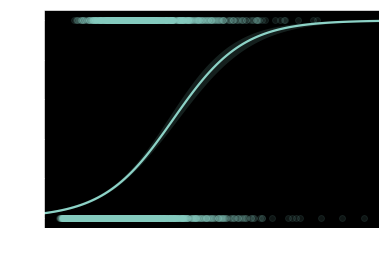

In [2]:
sns.regplot('X_max', 'outcome', df, scatter_kws={'alpha': 0.1}, logistic=True)
plt.hist(df['lifetime'][df['outcome']==0], alpha=0.5)
plt.hist(df['lifetime'][df['outcome']==1], alpha=0.5)
plt.show()

In [11]:
np.random.seed(42)
# make logistic data
model_type = 'rf'
feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement']
X = df[feat_names]
X = (X - X.mean()) / X.std()
y = df['outcome'].values


# split testing data based on cell num
idxs_test = df.cell_num.isin([5, 6])
X_test, Y_test = X[idxs_test], y[idxs_test]

if model_type == 'rf':
    m = RandomForestClassifier(n_estimators=100)
elif model_type == 'dt':
    m = DecisionTreeClassifier()
elif model_type == 'logistic':
    m = LogisticRegression(solver='lbfgs')

# scores = ['balanced_accuracy'] # ['accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc']
scorers = {'balanced_accuracy': metrics.balanced_accuracy_score, 'accuracy': metrics.accuracy_score,
           'precision': metrics.precision_score, 'recall': metrics.recall_score, 'f1': metrics.f1_score, 'roc_auc': metrics.roc_auc_score,
           'precision_recall_curve': metrics.precision_recall_curve, 'roc_curve': metrics.roc_curve}
scores_cv = {s: [] for s in scorers.keys()}
scores_test = {s: [] for s in scorers.keys()}
imps = {'model': [], 'imps': []}

kf = KFold(n_splits=4)
cell_nums_train = [1, 2, 3, 4]
for cv_idx, cv_val_idx in kf.split(cell_nums_train):
    # get sample indices
    idxs_cv = df.cell_num.isin(cv_idx + 1)
    idxs_val_cv = df.cell_num.isin(cv_val_idx + 1)
    X_train_cv, Y_train_cv = X[idxs_cv], y[idxs_cv]
    X_val_cv, Y_val_cv = X[idxs_val_cv], y[idxs_val_cv]
    
    
    # resample training data
    ros = RandomOverSampler(random_state=42)
    X_train_r_cv, Y_train_r_cv = ros.fit_resample(X_train_cv, Y_train_cv)

    # fit
    m.fit(X_train_r_cv, Y_train_r_cv)
    
    # get preds
    preds = m.predict(X_val_cv)
    preds_test = m.predict(X_test)
    preds_proba = m.predict_proba(X_val_cv)[:, 1]
    preds_test_proba = m.predict_proba(X_test)[:, 1]
    
    
    # add scores
    for s in scorers.keys():
        scorer = scorers[s]
        if 'roc' in s or 'curve' in s:
            scores_cv[s].append(scorer(Y_val_cv, preds_proba))
            scores_test[s].append(scorer(Y_test, preds_test_proba))
        else:
            scores_cv[s].append(scorer(preds, Y_val_cv))
            scores_test[s].append(scorer(preds_test, Y_test))
    imps['model'].append(deepcopy(m))
    imps['imps'].append(m.feature_importances_)

# save results
out_dir = 'results/classify'
os.makedirs(out_dir, exist_ok=True)
results = {'cv': scores_cv, 'test': scores_test, 'imps': imps}
pkl.dump(results, open(oj(out_dir, 'rf.pkl'), 'wb'))

metric                   	validation	test
balanced_accuracy        	0.797 ~ 0.028	0.793 ~ 0.007
accuracy                 	0.878 ~ 0.015	0.895 ~ 0.004
precision                	0.780 ~ 0.102	0.787 ~ 0.036
recall                   	0.652 ~ 0.096	0.627 ~ 0.017
f1                       	0.697 ~ 0.023	0.697 ~ 0.010
roc_auc                  	0.945 ~ 0.006	0.949 ~ 0.003

feature importances
X_max                    	0.215 ~ 0.013
lifetime                 	0.581 ~ 0.019
total_displacement       	0.092 ~ 0.005
mean_square_displacement 	0.113 ~ 0.004


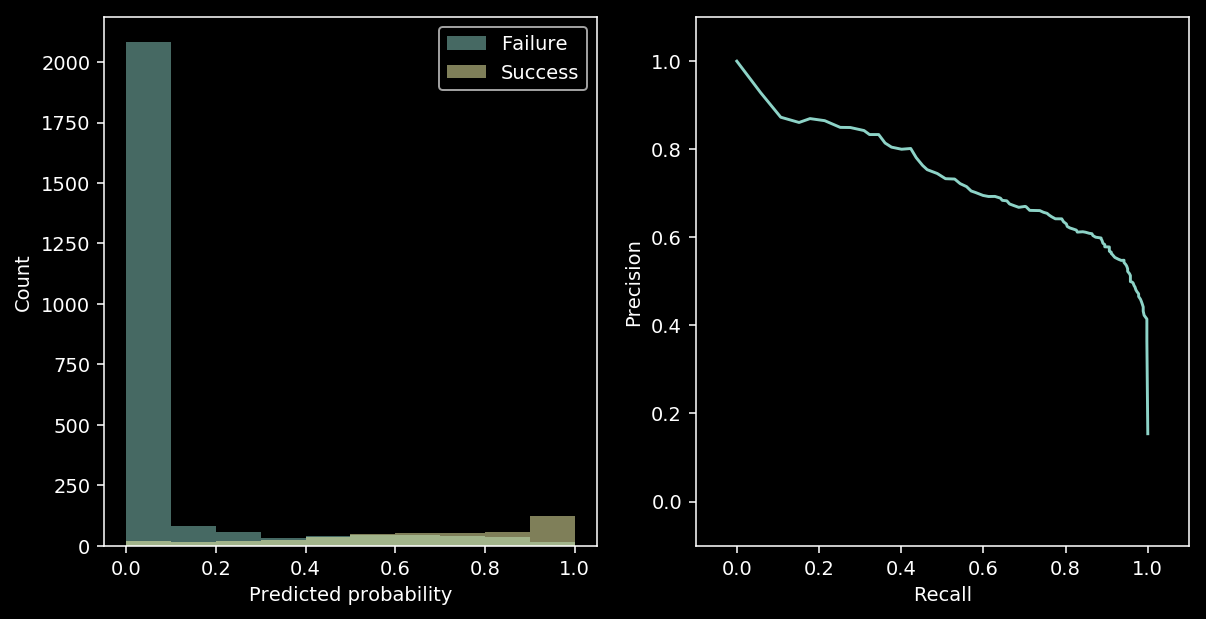

In [17]:
results = pkl.load(open(oj(out_dir, 'rf.pkl'), 'rb'))
scores_cv = results['cv']
scores_test = results['test']
imps = results['imps']
print(Fore.CYAN + f'{"metric":<25}\tvalidation\ttest')
for s in scorers.keys():
    if not 'curve' in s:
        print(Fore.WHITE + f'{s:<25}\t{np.mean(scores_cv[s]):.3f} ~ {np.std(scores_cv[s]):.3f}\t{np.mean(scores_test[s]):.3f} ~ {np.std(scores_test[s]):.3f}')

print(Fore.CYAN + '\nfeature importances')
imp_mat = np.array(imps['imps'])
imp_mu = imp_mat.mean(axis=0)
imp_sd = imp_mat.std(axis=0)
for i, feat_name in enumerate(feat_names):
    print(Fore.WHITE + f'{feat_name:<25}\t{imp_mu[i]:.3f} ~ {imp_sd[i]:.3f}')

# print(m.coef_)
plt.figure(figsize=(10, 5), dpi=140)
R, C = 1, 2
plt.subplot(R, C, 1)
preds = m.predict_proba(X_test)[:, 1]
plt.hist(preds[Y_test==0], alpha=0.5, label='Failure')
plt.hist(preds[Y_test==1], alpha=0.5, label='Success')
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.legend()

plt.subplot(R, C, 2)
prec, rec, thresh = scores_test['precision_recall_curve'][0]
plt.plot(rec, prec)
plt.xlim((-0.1, 1.1))
plt.ylim((-0.1, 1.1))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
# mat = deepcopy(X)
# mat['outcome'] = y_outcome
# sns.heatmap(mat.corr(method='pearson'))

# maxconv classifier

In [17]:
# predict using the trace
X_mat = data_tracks.extract_X_mat(df)
X_mat -= np.mean(X_mat)
X_mat /= np.std(X_mat)
outcome = df['outcome'].values.astype(np.int64)
X_train, X_test, Y_train, Y_test = train_test_split(X_mat, outcome, test_size=0.33, random_state=42)
ros = RandomOverSampler(random_state=42)
X_train_r, Y_train_r = ros.fit_resample(X_train, Y_train)

In [ ]:
conv_size = 20
num_channels = 3
dirname = oj('out', f'classification_conv_size={conv_size}_num_channels={num_channels}')

net = NeuralNetClassifier(
    nn.Sequential(models.MaxConv(kernel_size=conv_size, num_units=num_channels), 
                  nn.Linear(1, 2), nn.Softmax()),
    max_epochs=10000,
    lr=1e-3,
    iterator_train__shuffle=True,
    optimizer=torch.optim.SGD,
    callbacks=[Checkpoint(dirname=dirname)],
    device='cpu'
)

net.fit(X_train_r, Y_train_r)

Re-initializing optimizer.


/accounts/projects/vision/.local/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


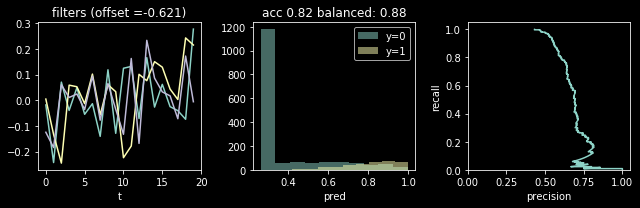

class imbalance 0.18
acc 0.82
roc_auc 0.88
balanced acc: 0.88


In [20]:
# load trained model and plot
net.initialize() # This is important!
net.load_params(
    f_params=oj(dirname, 'params.pt'), f_optimizer=oj(dirname, 'optimizer.pt'), f_history=oj(dirname, 'history.json')
)


R, C = 1, 3
plt.figure(figsize=(3 * C, 3 * R))
ws = net.module_.state_dict()['0.conv1.weight'].cpu().numpy().squeeze()
# print(ws.shape)

plt.subplot(R, C, 1)
plt.title(f'filters (offset ={net.module_.state_dict()["0.offset"].cpu().numpy().squeeze():0.3f})')
plt.plot(ws.T)
plt.xlabel('t')

plt.subplot(R, C, 2)
preds = net.predict_proba(X_test)
preds_labels = net.predict(X_test)
# plt.plot(Y_train, preds[:, 1], 'o', alpha=0.01)
plt.hist(preds[:, 1][Y_test == 0], label='y=0', alpha=0.5)
plt.hist(preds[:, 1][Y_test == 1], label='y=1', alpha=0.5)
plt.title(f'acc {np.mean(Y_test == preds_labels):0.2f} balanced: {metrics.balanced_accuracy_score(Y_test, preds_labels):0.2f}' ) #' r2 {metrics.r2_score(Y_train, preds):0.2f}')
# plt.xlabel('Y')
plt.legend()
plt.xlabel('pred')

plt.subplot(R, C, 3)
precision, recall, thresholds = metrics.precision_recall_curve(Y_test, preds[:, 1])
plt.plot(precision, recall)
plt.xlim((0, 1.05))
plt.ylim((0, 1.05))
plt.xlabel('precision')
plt.ylabel('recall')

plt.tight_layout()
plt.savefig(dirname + '.png')
plt.show()

print(f'class imbalance {np.mean(Y_test):0.2f}')
print(f'acc {np.mean(Y_test == preds_labels):0.2f}')
print(f'roc_auc {metrics.roc_auc_score(Y_test, preds_labels):0.2f}')
print(f'balanced acc: {metrics.balanced_accuracy_score(Y_test, preds_labels):0.2f}') #' r2 {metrics.r2_score(Y_train, preds):0.2f}')